In [1]:
import nibabel as nib
import numpy as np
import os
import cv2
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [2]:
def calculate_label(image, threshold=0.04):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(data_right)
                patient_data["mask_right"].append(data_msk_right)
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [ ]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip vertical
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.flipud(img)

    results_left = []
    results_right = []

    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate in [False, True]:
        for flip in [False, True]:
            for swap in [False, True]:
                if not (rotate or flip or swap):  # pula a imagem padrão
                    continue

                l_img = img_left.copy()
                r_img = img_right.copy()
                l_mask = mask_left.copy()
                r_mask = mask_right.copy()

                if rotate:
                    l_img = rotate_180(l_img)
                    r_img = rotate_180(r_img)
                    l_mask = rotate_180(l_mask)
                    r_mask = rotate_180(r_mask)

                if flip:
                    l_img = flip_vertical(l_img)
                    r_img = flip_vertical(r_img)
                    l_mask = flip_vertical(l_mask)
                    r_mask = flip_vertical(r_mask)

                if swap:
                    l_img, r_img = r_img, l_img
                    l_mask, r_mask = r_mask, l_mask

                results_left.append(l_img)
                results_right.append(r_img)

    return results_left, results_right
            
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [93]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    balanced_index_patients = {}

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-00H10', 'sub-02A13', 'sub-03C08', 'sub-14F04', 'sub-16E03', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-35E12', 'sub-36K02', 'sub-42K06', 'sub-44H05', 'sub-51C05', 'sub-52K04', 'sub-56E13', 'sub-59E09', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86G08']
    valid_patients = ['sub-06C09', 'sub-16G09', 'sub-22F14', 'sub-41D08', 'sub-42B05', 'sub-59G00', 'sub-60G06', 'sub-86B13']
    test_patients = ['sub-26B09', 'sub-31F07', 'sub-57D04', 'sub-79H07']

    # patients = list(set(images_left.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size+0.01)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        class_1_coordinates = {}
        class_0_coordinates = {}
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        
        if len(labels_pair[patient_id]) == 0:
            continue
        
        if patient_id in test_patients:
            balanced_images_left[patient_id] = images_left[patient_id]
            balanced_images_right[patient_id] = images_right[patient_id]
            balanced_labels[patient_id] = labels_pair[patient_id]
            balanced_mask_left[patient_id] = mask_left[patient_id]
            balanced_mask_right[patient_id] = mask_right[patient_id]
            continue
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            np.random.seed(np.random.choice(len(class_0_left[patient_id]), 1, replace=False))
            sampled_indices = np.random.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
            sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * (class_1_count)
        else:
            class_0_original_modified = class_0_left
            class_0_opposite_modified = class_0_right
            class_0_mask_original_modified = class_0_mask_left
            class_0_mask_opposite_modified = class_0_mask_right

        # # Fazer Uppersampling da classe minoritária (label 1) para igualar ao número de exemplos da classe 0
        # class_0_count = len(class_0_labels)
        # print(f"Paciente {patient_id}: Total de patches classe 0: {class_0_count}")
        # print(f"Paciente {patient_id}: Total de patches classe 1 antes do uppersampling: {class_1_count}")
        
        # # Se a classe 1 for menor, aplicamos data augmentation
        # if class_1_count < class_0_count:
        #     needed_samples_1 = class_0_count - class_1_count
        #     augmented_images_left = []
        #     augmented_images_right = []
        #     augmented_masks_left = []
        #     augmented_masks_right = []

        #     for _ in range(needed_samples_1):
        #         idx = np.random.randint(class_0_count)
        #         imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug = augment_image(class_0_left[patient_id][idx], class_0_right[patient_id][idx], class_0_mask_left[patient_id][idx], class_0_mask_right[patient_id][idx])
            
        #         for idx, (l_img, r_img, l_mask, r_mask) in enumerate(zip(imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug), start=2):  # começa no 2 porque a original é 1
                #     augmented_images_left.append(l_img)
                #     augmented_images_right.append(r_img)
                #     augmented_masks_left.append(l_mask)
                #     augmented_masks_right.append(r_mask)

        #     # Adiciona os dados aumentados
        #     class_1_left[patient_id].extend(augmented_images_left)
        #     class_1_right[patient_id].extend(augmented_images_right)
        #     class_1_mask_left[patient_id].extend(augmented_masks_left)
        #     class_1_mask_right[patient_id].extend(augmented_masks_right)
        #     class_1_labels.extend([1] * needed_samples_1)
        
            # needed_samples_0 = class_0_count - class_1_count
            # augmented_images_left = []
            # augmented_images_right = []
            # augmented_masks_left = []
            # augmented_masks_right = []

            # for _ in range(needed_samples_0//7):
            #     idx = np.random.randint(class_0_count)
            #     imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug = augment_image(class_0_left[patient_id][idx], class_0_right[patient_id][idx], class_0_mask_left[patient_id][idx], class_0_mask_right[patient_id][idx])
            
            #     for idx, (l_img, r_img, l_mask, r_mask) in enumerate(zip(imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug), start=2):  # começa no 2 porque a original é 1
                #     augmented_images_left.append(l_img)
                #     augmented_images_right.append(r_img)
                #     augmented_masks_left.append(l_mask)
                #     augmented_masks_right.append(r_mask)

            # # Adiciona os dados aumentados
            # class_0_left[patient_id].extend(augmented_images_left)
            # class_0_right[patient_id].extend(augmented_images_right)
            # class_0_mask_left[patient_id].extend(augmented_masks_left)
            # class_0_mask_right[patient_id].extend(augmented_masks_right)
            # class_0_labels.extend([0] * ((needed_samples_0//7)*7))
            
        # class_1_count = len(class_1_labels)
        # print(f"Paciente {patient_id}: Total de patches classe 1 depois do uppersampling: {class_1_count}")
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        balanced_index = np.random.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        balanced_index_patients[patient_id] = balanced_index
    
    class_1_count = len(class_1_labels)
    class_0_count = len(class_0_labels)
    print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_left, balanced_images_right, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients

In [5]:
# Função para construir o modelo CNN 2D
def build_cnn_model_backup():
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(16, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4)) 
     
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())

    return model


In [6]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    # Criar a CNN base compartilhada
    cnn_base = build_cnn_model_backup()
    
    # Aplicar a mesma CNN base para ambas as entradas
    output_original = cnn_base(input_original)
    output_opposite = cnn_base(input_opposite)

    # Calcula a diferença absoluta
    # l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_original, output_opposite])

    # Subtrair as duas saídas (Lado esquerdo - Contra-lateral)
    subtracted = layers.Subtract()([output_original, output_opposite])

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    # concatenated = layers.Concatenate()([output_original, output_opposite])
    # concatenated = layers.BatchNormalization()(concatenated)
    
    # Passar o resultado pela rede densa
    subtracted = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(subtracted)
    subtracted = layers.Dense(32, activation='relu')(subtracted)
    

    output = layers.Dense(1, activation='sigmoid')(subtracted)

    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model


In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [8]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [9]:

# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1134
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1150
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 1013
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1122
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1187
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1263
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 1136
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 1209
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 1229
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 1134
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 1156
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 1229
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 1185
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 1106
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 1132
Paciente s

In [94]:
# Preparar dados para treino, validação e teste
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

41
Paciente sub-00H10: Total de pares de recortes com labels 1: 16
Paciente sub-02A13: Total de pares de recortes com labels 1: 97
Paciente sub-03C08: Total de pares de recortes com labels 1: 49
Paciente sub-06C09: Total de pares de recortes com labels 1: 10
Paciente sub-14F04: Total de pares de recortes com labels 1: 10
Paciente sub-16E03: Total de pares de recortes com labels 1: 75
Paciente sub-16G09: Total de pares de recortes com labels 1: 105
Paciente sub-16I12: Total de pares de recortes com labels 1: 27
Paciente sub-19F09: Total de pares de recortes com labels 1: 177
Paciente sub-19G04: Total de pares de recortes com labels 1: 37
Paciente sub-22F14: Total de pares de recortes com labels 1: 63
Paciente sub-25B08: Total de pares de recortes com labels 1: 95
Paciente sub-29D03: Total de pares de recortes com labels 1: 72
Paciente sub-34J06: Total de pares de recortes com labels 1: 137
Paciente sub-35E12: Total de pares de recortes com labels 1: 58
Paciente sub-36K02: Total de pares

In [95]:
# Adiciono camada de cor
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)
test_left = normalize_minmax(np.array([elemento for lista in test_left.values() for elemento in lista]))
test_left = np.expand_dims(test_left, axis=-1)
test_right = normalize_minmax(np.array([elemento for lista in test_right.values() for elemento in lista]))
test_right = np.expand_dims(test_right, axis=-1)

In [12]:
# Construir e compilar o modelo CNN
input_shape = (train_left_balanced[0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 40, 40, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256)                  24864     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 256)                  0         ['sequential[0][0]',    

In [13]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Ajusta learning rate
# reduce_lr = callbacks.ReduceLROnPlateau(factor=0.8, patience=15, verbose=1)

# Suponha que seus rótulos estejam em y_train_balanced
# classes = np.unique(y_valid_balanced)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_valid_balanced)
# class_weight_dict = dict(zip(classes, weights))

# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True,  save_weights_only=True, mode='min')

# Treinamento do modelo siames
history = siamese_model.fit([train_left_balanced, train_right_balanced], y_train_balanced, validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced), batch_size=64, epochs=150, callbacks=[checkpoint])

Epoch 1/150


74/74 [==============================] - 4s 24ms/step - loss: 2.1934 - accuracy: 0.4972 - precision: 0.4978 - recall: 0.6410 - val_loss: 1.6920 - val_accuracy: 0.4702 - val_precision: 0.1613 - val_recall: 0.0142
Epoch 2/150
74/74 [==============================] - 1s 19ms/step - loss: 1.9055 - accuracy: 0.5009 - precision: 0.5009 - recall: 0.4808 - val_loss: 1.6493 - val_accuracy: 0.5043 - val_precision: 0.5061 - val_recall: 0.3537
Epoch 3/150
74/74 [==============================] - 1s 18ms/step - loss: 1.8049 - accuracy: 0.5181 - precision: 0.5194 - recall: 0.4838 - val_loss: 1.5921 - val_accuracy: 0.6037 - val_precision: 0.5877 - val_recall: 0.6946
Epoch 4/150
74/74 [==============================] - 1s 18ms/step - loss: 1.7155 - accuracy: 0.5224 - precision: 0.5244 - recall: 0.4813 - val_loss: 1.5467 - val_accuracy: 0.6207 - val_precision: 0.5977 - val_recall: 0.7386
Epoch 5/150
74/74 [==============================] - 1s 19ms/step - loss: 1.6488 - accuracy: 0.5420 - 

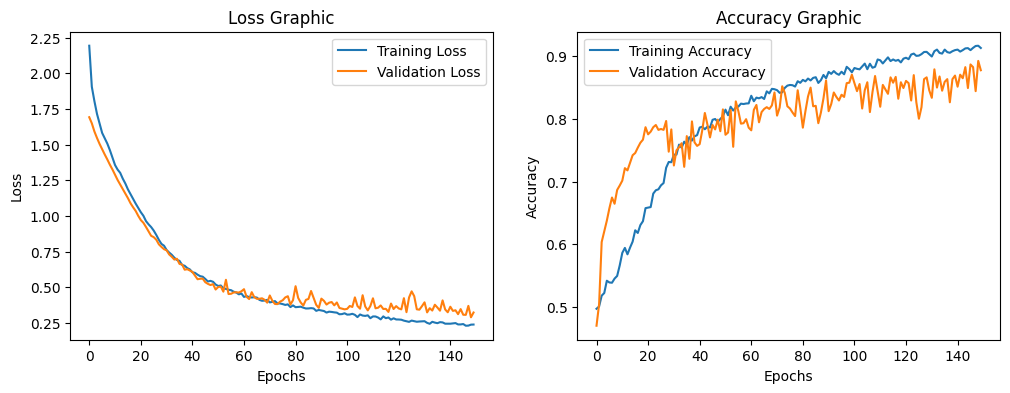

In [14]:
# Plotar o histórico do treinamento
plot_training_history(history)

142/142 [==============================] - 2s 15ms/step


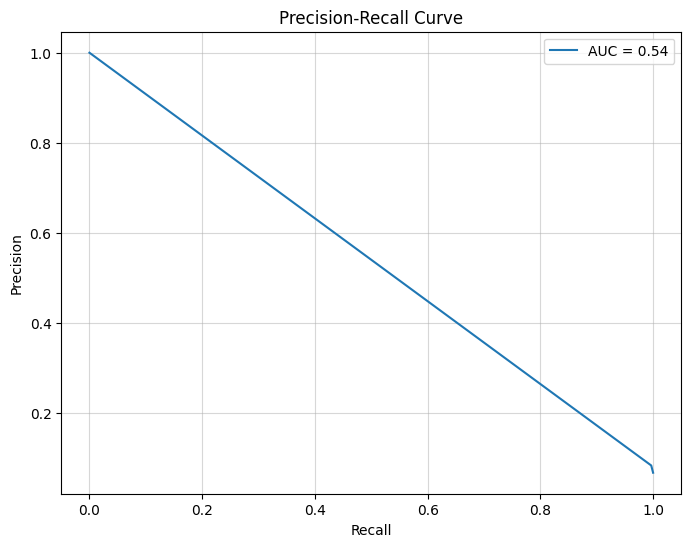

In [96]:
# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

# Avaliar o modelo na validação
y_pred_train = (siamese_model.predict([train_left_balanced, train_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo na validação
y_pred_valid = (siamese_model.predict([valid_left_balanced, valid_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo no teste
y_pred_test = (siamese_model.predict([test_left, test_right]) > 0.5).astype(int)

# Calcula a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)

# Calcula a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [97]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(y_valid_balanced, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
#print(classification_report(y_test, y_pred_test)) 
print(classification_report(y_test, y_pred_test)) 

Validação:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       704
           1       0.87      0.93      0.90       704

    accuracy                           0.89      1408
   macro avg       0.89      0.89      0.89      1408
weighted avg       0.89      0.89      0.89      1408


#########################################################

Teste:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35      4218
           1       0.08      1.00      0.15       300

    accuracy                           0.26      4518
   macro avg       0.54      0.60      0.25      4518
weighted avg       0.94      0.26      0.34      4518



Validação:


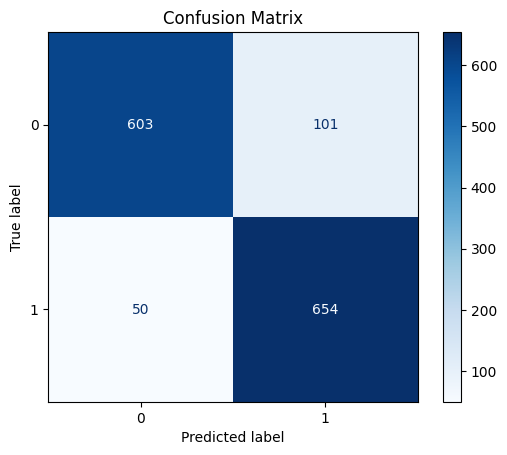


#########################################################

Teste:


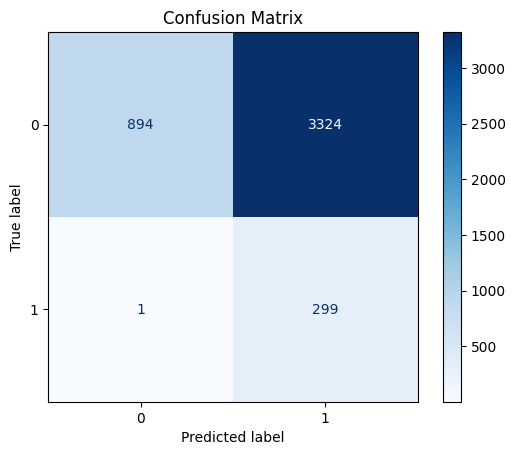

In [98]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_balanced, y_pred_valid)
print("\n#########################################################\n")
print("Teste:")
#plot_confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(y_test, y_pred_test)

In [99]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_normalized = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index
    
    reconstructed_img = np.zeros((233, 197, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((233, 197, 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    classifications = []
    classifications_right = []
    
    # Determinar a classificação de cada patch
    half = len(coordinates) // 2

    if half == 1:
        axs = [axs]  # Handle single patch pair case

    for i in range(half):
        if labels_pred[i+index] == labels_true[i+index]:
            if labels_pred[i+index] == 1:
                classification = "TP"
            else:
                classification = "TN"
        else:
            if labels_pred[i+index] == 1:
                classification = "FP"
            else:
                classification = "FN"
        classifications.append(classification)
        classifications_right.append(classification)
        
    # Sincronizar classificações entre os lados do cérebro
    classifications.extend(classifications_right)
    
    # Reconstruir a imagem com base nas classificações sincronizadas
    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classification = classifications[i]
        
        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        bordered_patch_img = add_border(patch_img, colors[classification])
        bordered_patch_mask = add_border(patch_mask, colors[classification])
        
        # Inserir os patches na imagem reconstruída
        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask
    
    return reconstructed_img, reconstructed_mask, (index+half)


In [90]:
# Função para gerar PDF reconstruido
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-26B09': 1185, 'sub-31F07': 1132, 'sub-57D04': 1188, 'sub-79H07': 1013}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias",
    mask_path="Mask_Fatias",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

As imagens foram salvas no arquivo PDF Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Undersampling.pdf com sucesso.


In [91]:
# Função para gerar PDF sem reconstruir
def plot_patient_patches(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img = load_nii_slice(patient, slice_index, image_path)
                mask = load_nii_slice(patient, slice_index, mask_path)
                coordinates = load_coordinates(patient, slice_index, coordinates_path)
                
                if img is None or mask is None or not coordinates:
                    continue

                colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
                classifications = []
                classifications_right = []
                
                # Determinar a classificação de cada patch
                half = len(coordinates) // 2

                if half == 1:
                    axs = [axs]  # Handle single patch pair case

                for i in range(half):
                    if labels_pred[i+index] == labels_true[i+index]:
                        if labels_pred[i+index] == 1:
                            classification = "TP"
                        else:
                            classification = "TN"
                    else:
                        if labels_pred[i+index] == 1:
                            classification = "FP"
                        else:
                            classification = "FN"
                    classifications.append(classification)
                    classifications_right.append(classification)

                # Sincronizar classificações entre os lados do cérebro
                classifications.extend(classifications_right)

                half = len(coordinates) // 2
                fig, axs = plt.subplots(half, 4, figsize=(8, half * 2))  # 2 patches per row: image + mask

                if half == 1:
                    axs = [axs]  # Handle single patch pair case

                for i in range(half):
                    # Get both contralateral patches
                    (y1a, y2a, x1a, x2a) = coordinates[i]
                    (y1b, y2b, x1b, x2b) = coordinates[i + half]

                    patch_img_a = img[y1a+3:y2a-3, x1a+3:x2a-3]
                    patch_mask_a = mask[y1a+3:y2a-3, x1a+3:x2a-3]

                    patch_img_b = img[y1b+3:y2b-3, x1b+3:x2b-3]
                    patch_mask_b = mask[y1b+3:y2b-3, x1b+3:x2b-3]

                    classification_a = classifications[i]
                    classification_b = classifications[i + half]

                    color_a = colors[classification_a]
                    color_b = colors[classification_b]

                    bordered_img_a = add_border(patch_img_a, color_a)
                    bordered_mask_a = add_border(patch_mask_a, color_a)

                    bordered_img_b = add_border(patch_img_b, color_b)
                    bordered_mask_b = add_border(patch_mask_b, color_b)

                    # Left patch (image + mask)
                    axs[i][0].imshow(bordered_img_a)
                    axs[i][0].set_title(f"Patch left - {classification_a}")
                    axs[i][0].axis("off")

                    axs[i][2].imshow(bordered_mask_a)
                    axs[i][2].set_title(f"Mask left - {classification_a}")
                    axs[i][2].axis("off")

                    # Right patch (image + mask)
                    axs[i][1].imshow(bordered_img_b)
                    axs[i][1].set_title(f"Patch right - {classification_b}")
                    axs[i][1].axis("off")

                    axs[i][3].imshow(bordered_mask_b)
                    axs[i][3].set_title(f"Mask right - {classification_b}")
                    axs[i][3].axis("off")

                fig.suptitle(f"Paciente {patient} - Fatia {slice_index}")
                pdf.savefig(fig)
                plt.close(fig)
                index += half

        print(f"Patches com bordas salvos em {pdf_filename}")

plot_patient_patches(
    pdf_filename="Pdf_SNN/Pacientes_Test_Patches_SemReconstrucao.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias",
    mask_path="Mask_Fatias",
    labels_true=y_test,
    labels_pred=y_pred_test
)


Patches com bordas salvos em Pdf_SNN/Pacientes_Test_Patches_SemReconstrucao.pdf


In [105]:
# Função para gerar PDF sem reconstruir
def plot_patient_patches_with_undersampling(pdf_filename, patients, images_left, images_right, masks_left, masks_right, labels_true, labels_pred, balanced_index_by_patients):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            print(f"\n🔍 Paciente: {patient}")
            indices = balanced_index_by_patients.get(patient, [])
            print(f"📊 Número de pares após undersampling: {len(indices)}")
            for i in range (len(indices)):
                colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
                classifications = []
                
                if labels_pred[i+index] == labels_true[i+index]:
                    if labels_pred[i+index] == 1:
                        classification = "TP"
                    else:
                        classification = "TN"
                else:
                    if labels_pred[i+index] == 1:
                        classification = "FP"
                    else:
                        classification = "FN"
                classifications.append(classification)

                color = colors[classification]

                # Pega patches esquerdo e direito e máscaras
                patch_left = images_left[i+index]
                patch_right = images_right[i+index]
                mask_l = masks_left[patient][i]
                mask_r = masks_right[patient][i]

                # Aplica borda nos patches e máscaras
                bordered_patch_left = add_border(patch_left, color)
                bordered_patch_right = add_border(patch_right, color)
                bordered_mask_left = add_border(mask_l, color)
                bordered_mask_right = add_border(mask_r, color)

                # Plotagem
                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(bordered_patch_left)
                axs[0, 0].set_title("Img Esq")
                axs[0, 1].imshow(bordered_patch_right)
                axs[0, 1].set_title("Img Dir")
                axs[1, 0].imshow(bordered_mask_left)
                axs[1, 0].set_title("Mask Esq")
                axs[1, 1].imshow(bordered_mask_right)
                axs[1, 1].set_title("Mask Dir")

                for ax in axs.flat:
                    ax.axis('off')

                fig.suptitle(f"Paciente: {patient}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)
            index += len(indices)

        print(f"Patches com bordas salvos em {pdf_filename}")

plot_patient_patches_with_undersampling(
    pdf_filename="Pdf_SNN/Pacientes_Train_Patches_SemReconstrucao.pdf",
    patients=train_patients,
    images_left=train_left_balanced,
    images_right=train_right_balanced,
    masks_left=balanced_mask_left,
    masks_right=balanced_mask_right,
    labels_true=y_train_balanced,
    labels_pred=y_pred_train,
    balanced_index_by_patients=balanced_index_patients
)

plot_patient_patches_with_undersampling(
    pdf_filename="Pdf_SNN/Pacientes_Valid_Patches_SemReconstrucao.pdf",
    patients=valid_patients,
    images_left=valid_left_balanced,
    images_right=valid_right_balanced,
    masks_left=balanced_mask_left,
    masks_right=balanced_mask_right,
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_by_patients=balanced_index_patients
)


🔍 Paciente: sub-00H10
📊 Número de pares após undersampling: 32

🔍 Paciente: sub-02A13
📊 Número de pares após undersampling: 194

🔍 Paciente: sub-03C08
📊 Número de pares após undersampling: 98

🔍 Paciente: sub-14F04
📊 Número de pares após undersampling: 20

🔍 Paciente: sub-16E03
📊 Número de pares após undersampling: 150

🔍 Paciente: sub-16I12
📊 Número de pares após undersampling: 54

🔍 Paciente: sub-19F09
📊 Número de pares após undersampling: 354

🔍 Paciente: sub-19G04
📊 Número de pares após undersampling: 74

🔍 Paciente: sub-25B08
📊 Número de pares após undersampling: 190

🔍 Paciente: sub-29D03
📊 Número de pares após undersampling: 144

🔍 Paciente: sub-34J06
📊 Número de pares após undersampling: 274

🔍 Paciente: sub-35E12
📊 Número de pares após undersampling: 116

🔍 Paciente: sub-36K02
📊 Número de pares após undersampling: 44

🔍 Paciente: sub-42K06
📊 Número de pares após undersampling: 132

🔍 Paciente: sub-44H05
📊 Número de pares após undersampling: 236

🔍 Paciente: sub-51C05
📊 Número